In [2]:
import time
from datasets import load_dataset

In [1]:
import pandas as pd
from transformers import pipeline
import whisper

childrens_speech = pd.read_pickle('./asr_data/childrens_speech')
childrens_speech['duration'] = [len(audio) / 22500 for audio in childrens_speech['audio']]

In [ ]:
from transformers import pipeline
import whisper

# options = {"language"="en", "without_timestamps"=True}
model_wav = pipeline(task='automatic-speech-recognition',
                 model='facebook/wav2vec2-large-960h')

model_whisp = whisper.load_model('tiny.en')
def transcribe(model, audio):
    """
    Given a model transcribe audio to text

    args: 
        model: str specifiy either whisper or wav2vec2  
    
    """
    if 'wav' in model:

        text = model_wav(audio) 
        return text
    elif '.en' in model:
    
        text = model_whisp.transcribe(audio, without_timestamps=True, language='en', temperature=0.2)
        return text['text']


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
childrens_speech['audio']   

0      [0.009646121, 0.021695968, 0.022539534, 0.0212...
1      [0.027527185, 0.032552492, 0.012983527, 0.0112...
2      [-0.03888016, -0.057698667, -0.045864653, -0.0...
3      [0.04435131, 0.06784426, 0.058827527, 0.077713...
4      [0.025824236, 0.029695712, 0.02606499, 0.03642...
                             ...                        
634    [-0.025713801, -0.044510987, -0.041728463, -0....
635    [0.010593225, 0.016391743, 0.012017116, 0.0188...
636    [0.015749954, 0.023017816, 0.018736875, 0.0202...
637    [-0.050608773, -0.07725125, -0.06856466, -0.07...
638    [0.008249281, 0.016108418, 0.007817927, 0.0006...
Name: audio, Length: 639, dtype: object

In [ ]:
import pandas as pd
import statistics
from regex import R
from tqdm.notebook import tqdm

rtf_data = pd.DataFrame()
rtf_data['model'] = ['small.en']

# samples = 100
# Init data
dataset = childrens_speech
# dataset = childrens_speech['audio']

# For each model size
for i, model in enumerate(rtf_data['model']):

    inference_times = []
    sample_durations = []
    rtfs = []
    # dataset.at[i, 'model'] = model    
    # For each audio file in the dataset 
    for j, data in tqdm(dataset.iterrows()):
        audio = data['audio']
        # audio = audio['array']
        # Start the counter
        # Starting the counter here takes into account the 
        #   - load time
        #   - encoding time
        #   - decoding time
        start = time.perf_counter()
        text = transcribe(model, audio)
        print(text)
        inf_time = time.perf_counter() - start
        
        SAMPLE_RATE = 22500.0
        sample_duration = len(list(audio)) / SAMPLE_RATE  
        rtf = inf_time / sample_duration

        dataset.at[j, 'inf'] = inf_time
        dataset.at[j, 'rtf'] = rtf
      

        # Store data
        inference_times.append(inf_time)
        sample_durations.append(sample_duration)
        rtfs.append(rtf)

    # append mean infereance time to the correspond model size row
    rtf_data.at[i, 'av_inf_time'] = statistics.mean(inference_times)
    rtf_data.at[i, 'av_duration'] = statistics.mean(sample_durations)
    rtf_data.at[i, 'duration_std'] = statistics.stdev(sample_durations)

    rtf_data.at[i, 'av_RTF'] = statistics.fmean(rtfs)
    rtf_data.at[i, 'RTF_std'] = statistics.stdev(rtfs)
    
dataset = dataset.sort_values('duration')
# dataset
rtf_data


0it [00:00, ?it/s]

 Three.
 10.
 Nine
 Ew.
 Bye!
 two
 6
 Eight.
 Seven
 One
 The horse is behind the car.
 The fish is a new point.
 The horse is next to the staple.
 The door case in front of the house.
 The dog is on top of the shed.
 The dog is in front of the horse.


KeyboardInterrupt: 

In [ ]:
# dataset.to_pickle('RTFdata_no_load_{samples} samples')
# dataset_wav = dataset[dataset['model'] == 'wav'].sort_values('duration')
# dataset_tiny = dataset[dataset['model'] == 'tiny.en'].sort_values('duration')
# dataset.to_pickle('base_628_samples')

In [55]:
import numpy as np

base = pd.read_pickle('./base_628_samples')
base['Model'] = 'Base'
Tiny = pd.read_pickle('./whisper_638_sample')
a, b = np.polyfit(Tiny['duration'], Tiny['inf'], deg=1)

Tiny['Model'] = f'Tiny: y = {round(a,2)} x + {round(b,2)}'
wav = pd.read_pickle('./RTFwav2Vec2_638_sample')
a, b = np.polyfit(wav['duration'], wav['inf'], deg=1)

wav['Model'] = f'Wav2Vec2: y = {round(a,2)} x + {round(b,2)}'

wav_pi = pd.read_pickle('./Pi_wav')
a, b = np.polyfit(wav_pi['duration'], wav_pi['inf'], deg=1)

wav_pi['Model'] = f'Wav2Vec2 Pi: y = {round(a,2)} x + {round(b,2)}'

tiny_pi = pd.read_pickle('./Pi_tiny.en')
tiny_pi = tiny_pi.drop(index=538)
a, b = np.polyfit(tiny_pi['duration'], tiny_pi['inf'], deg=1)

tiny_pi['Model'] = f'Tiny Pi: y = {round(a,2)} x + {round(b,2)}'

big_data = pd.concat([Tiny, tiny_pi, wav, wav_pi ], axis=0, ignore_index=True)
# big_data = pd.concat([Tiny, wav], axis=0, ignore_index=True)
big_data


,text,audio,file_name,duration,inf,rtf,Model
0,one,"[-0.024502916, -0.03965207, -0.020244993, -0.0...",english_children/english_words_sentences/05_F_...,0.384978,0.620269,1.611181,Tiny: y = 0.05 x + 0.49
1,one,"[0.005449832, 0.004330259, -0.014099253, -0.02...",english_children/english_words_sentences/05_F_...,0.384978,0.548181,1.423928,Tiny: y = 0.05 x + 0.49
2,one,"[0.08587232, 0.12102143, 0.08998285, 0.0949157...",english_children/english_words_sentences/05_F_...,0.384978,0.460679,1.196639,Tiny: y = 0.05 x + 0.49
3,three,"[-0.0095667485, -0.013219239, -0.033976406, -0...",english_children/english_words_sentences/06_M_...,0.429600,0.414439,0.964708,Tiny: y = 0.05 x + 0.49
4,three,"[-0.06570174, -0.128973, -0.14236665, -0.12020...",english_children/english_words_sentences/06_M_...,0.429600,0.405846,0.944706,Tiny: y = 0.05 x + 0.49
...,...,...,...,...,...,...,...
2550,the boy looked in the shouting in the hole fro...,"[-0.00055857835, -0.001537919, -0.0012469826, ...",english_children/english_free_speech/files_cut...,9.329867,51.275890,5.495887,Wav2Vec2 Pi: y = 5.34 x + 1.5
2551,then the deer have seen him then they came wit...,"[-0.061947174, -0.08557514, -0.06836137, -0.06...",english_children/english_free_speech/files_cut...,10.104711,55.391063,5.481707,Wav2Vec2 Pi: y = 5.34 x + 1.5
2552,the dog looked at the hat and the dog look in ...,"[-0.015816193, -0.020369168, -0.009165357, -0....",english_children/english_free_speech/files_cut...,10.404356,60.683079,5.832469,Wav2Vec2 Pi: y = 5.34 x + 1.5
2553,the dog and and and the boy is looking at the ...,"[-0.06541623, -0.09811183, -0.0886256, -0.0911...",english_children/english_free_speech/files_cut...,11.662133,67.930020,5.824836,Wav2Vec2 Pi: y = 5.34 x + 1.5


0.4915827443722209

/Users/ryanselesnik/dev/AI-toy-investigation/repo/src/backend/venv/lib/python3.8/site-packages/seaborn/regression.py:582: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


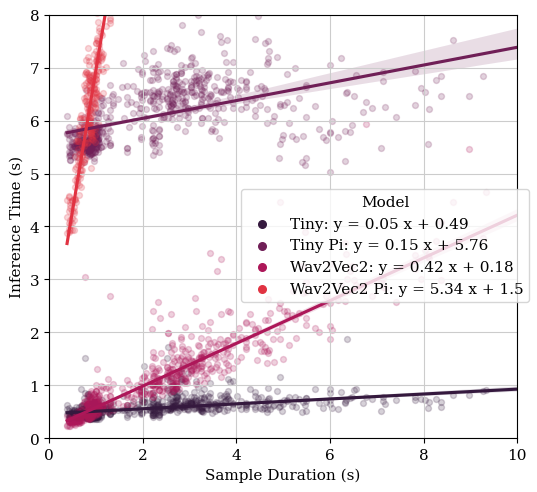

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
rc = {'figure.figsize': (5, 5),
      'axes.facecolor': 'white',
      'axes.grid': True,
      'grid.color': '.8',
      'font.family': 'Serif',
      'font.size': 11 }
plt.rcParams.update(rc)
sns.set_palette("rocket")
plot = sns.lmplot(data=big_data,
                  x="duration",
                  y="inf",
                  robust=True,
                  hue='Model',
                  scatter_kws={'s': 18, 'alpha': 0.2},
                  aspect=1.1,
                  legend_out=False
                  )

plot.set(xlabel='Sample Duration (s)', ylabel='Inference Time (s)')
sns.move_legend(plot, "upper right")
sns.despine(fig=None, ax=None, top=False, right=False,
            left=False, bottom=False, offset=None, trim=False)
for lh in plot._legend.legendHandles:
    lh.set_alpha(1)
    lh._sizes = [20] 
    
    lh.set_label('x')
    
# plt.legend(title='Model', loc='upper right',
#                labels=['Tiny: y = 3x +3', 'Wav2Vec2', 'Tiny Pi: y = 4x+3', 'Wav2vec2 Pi'])

plt.ylim(0,10)
plt.xlim(0,10)
plt.show(plot)
fig = plot.fig
fig.savefig(f'Mac.pdf')


(array([0.50390584, 0.04319193, 0.10078117, 0.04319193, 0.01439731,
        0.        , 0.        , 0.        , 0.        , 0.01439731]),
 array([ 1.00128637,  2.39043478,  3.7795832 ,  5.16873161,  6.55788003,
         7.94702844,  9.33617686, 10.72532527, 12.11447369, 13.5036221 ,
        14.89277052]),
 <BarContainer object of 10 artists>)

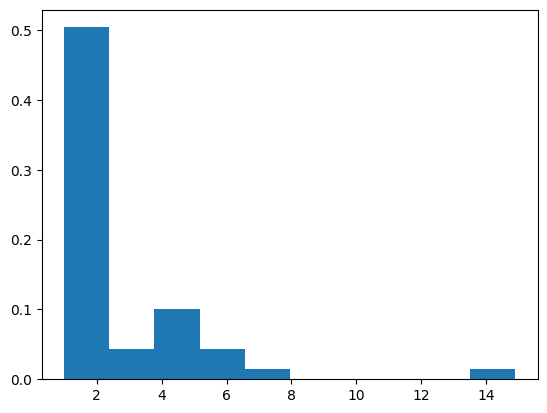

In [ ]:
plt.hist(dataset['inf'], density=True)

In [ ]:
import IPython

IPython.display.Audio(data=dataset[2], rate=22500)


In [ ]:
rtf_data


,model,av_inf_time,av_duration,duration_std,av_RTF,RTF_std
0,tiny.en,1.755711,2.463612,1.606676,1.032647,0.971657
1,base.en,4.876610,2.463612,1.606676,3.253959,5.616636
2,small.en,13.352413,2.463612,1.606676,8.077425,10.379376


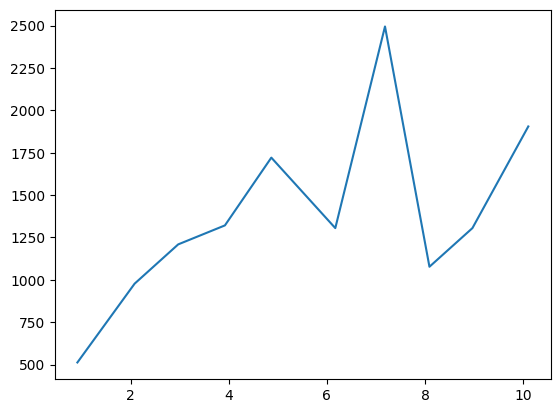

In [ ]:
import matplotlib.pyplot as plt
d = {'duration': [0.914, 2.08, 2.969, 3.921, 4.867, 6.171, 7.184, 8.090, 8.966, 10.105],
     'total CPU memory': [1065.88, 1115.46, 1095.19, 1075.71, 1214.86, 1084.92, 1096.75, 1114.98, 1085.16, 1092.8],
     'number of calls': [512, 977, 1209, 1321, 1721, 1305, 2495, 1077, 1305, 1905]}
plt.plot(d['duration'], d['number of calls'])
